In [49]:
import pandas as pd
from utils.data_utils import load_datasets
from utils.submission_utils import *
import holidays
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

traffic_train = pd.read_csv("../../datasets/training_data.csv", keep_default_na=False, encoding='latin1')
traffic_test = pd.read_csv("../../datasets/test_data.csv", keep_default_na=False, encoding='latin1')

**Data Preparation**

Remoção de colunas não necessárias:
- city_name e AVERAGE_PRECIPITATION porque é só um valor.
- AVERAGE_CLOUDINESS por causa dos missing values.
- AVERAGE_RAIN por causa dos missing values.
- AVERAGE_HUMIDITY tem grande correlação.

In [50]:
# Drop unnecessary columns 
for df in [traffic_train, traffic_test]:
    df.drop(columns=['city_name'], inplace=True)
    df.drop(columns=['AVERAGE_PRECIPITATION'], inplace=True)
    df.drop(columns=['AVERAGE_RAIN'], inplace=True)
    df.drop(columns=['AVERAGE_CLOUDINESS'], inplace=True)

Extração de campos do atributo da data.

In [51]:
# Date Treatment
for df in [traffic_train, traffic_test]:
    df['record_date'] = pd.to_datetime(df['record_date'])
    df['hour'] = df['record_date'].dt.hour
    df['day_of_week'] = df['record_date'].dt.dayofweek
    df['month'] = df['record_date'].dt.month
    df['year'] = df['record_date'].dt.year


**Feature Engineering:**

Criação de features para acrescentar valores e atributos ao dataset:
- is_weekend por causa do fim de semana.
- is_friday por causa de ser sexta-feira.
- is_holiday por causa de ser feriado.
- is_rush_hour por causa das horas de ponta.
- season por causa da estação do ano.

In [52]:
# Feature Engineering
pt_holidays = holidays.Portugal()

def daypart(hour):
    if hour > 0 and hour <= 8:
        return "night"
    elif hour > 8 and hour <= 16:
        return "work"
    else: return "free_time"

for df in [traffic_train, traffic_test]:
    df['is_weekend'] = df['record_date'].dt.weekday.isin([5, 6]).astype(int)
    df['is_friday'] = (df['record_date'].dt.weekday == 4).astype(int)
    df['is_holiday'] = df['record_date'].dt.date.map(lambda d: d in pt_holidays).astype(int)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    df['season'] = pd.cut(df['month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
    df.drop(columns=['record_date'], inplace=True)

'''
for df in [traffic_train, traffic_test]:
    df['Day_Part'] = df['hour'].apply(daypart)
    one_hot_dates = pd.get_dummies(df['Day_Part'])
    del df['Day_Part']
    df = pd.concat([df, one_hot_dates], axis=1) '''

"\nfor df in [traffic_train, traffic_test]:\n    df['Day_Part'] = df['hour'].apply(daypart)\n    one_hot_dates = pd.get_dummies(df['Day_Part'])\n    del df['Day_Part']\n    df = pd.concat([df, one_hot_dates], axis=1) "

**Categorical Encoding**

Fazer enconding de todas as features categóricas para poder trabalhar com os modelos.

In [53]:
# Categorical Encoding
speed_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
traffic_train['AVERAGE_SPEED_DIFF'] = traffic_train['AVERAGE_SPEED_DIFF'].map(speed_map).astype(int)

luminosity_map = {'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2}
traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)

rush_hour_map = {'True': 1, 'False': 0}
traffic_train['is_rush_hour'] = traffic_train['is_rush_hour'].replace(rush_hour_map).astype(int)
traffic_test['is_rush_hour'] = traffic_test['is_rush_hour'].replace(rush_hour_map).astype(int)

season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
traffic_test['season'] = traffic_test['season'].replace(season_map).astype(int)

C:\Users\rodme\AppData\Local\Temp\ipykernel_13676\2237372246.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_13676\2237372246.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_13676\2237372246.py:14: FutureWarning: Downcasting behavior in `replace` is depr

**Tratamento de Outliers**
 -> Aqui faz-se uma substituição dos outliers pelos valores mais próximos permitidos em termos de percentis divisão.

**A fazer (testar combinações)**
- Gráficos de caixas de bigodes no dataPreparation para ver os outliers.
- Substituir outliers pela média ou assim e normalizar.
- Fazer só com outliers sem winsorize.
- Quantis puros.

In [54]:
# Outlier Treatment
from scipy.stats.mstats import winsorize

for df in [traffic_train, traffic_test]:
    df['AVERAGE_FREE_FLOW_TIME'] = winsorize(df['AVERAGE_FREE_FLOW_TIME'], limits=[0.01, 0.01])
    df['AVERAGE_FREE_FLOW_SPEED'] = winsorize(df['AVERAGE_FREE_FLOW_SPEED'], limits=[0.05, 0.01])
    df['AVERAGE_TEMPERATURE'] = winsorize(df['AVERAGE_TEMPERATURE'], limits=[0.01, 0.02])
    df['AVERAGE_ATMOSP_PRESSURE'] = winsorize(df['AVERAGE_ATMOSP_PRESSURE'], limits=[0.05, 0.015])
    df['AVERAGE_WIND_SPEED'] = winsorize(df['AVERAGE_WIND_SPEED'], limits=[0.01, 0.03])
    df['AVERAGE_TIME_DIFF'] = winsorize(df['AVERAGE_TIME_DIFF'], limits=[0, 0.025])

In [6]:
# Outlier Treatment
from scipy.stats.mstats import winsorize

for df in [traffic_train, traffic_test]:
    df['AVERAGE_FREE_FLOW_TIME'] = winsorize(df['AVERAGE_FREE_FLOW_TIME'], limits=[0.01, 0.01])
    df['AVERAGE_FREE_FLOW_SPEED'] = winsorize(df['AVERAGE_FREE_FLOW_SPEED'], limits=[0.05, 0.01])
    df['AVERAGE_TEMPERATURE'] = winsorize(df['AVERAGE_TEMPERATURE'], limits=[0.01, 0.02])
    df['AVERAGE_ATMOSP_PRESSURE'] = winsorize(df['AVERAGE_ATMOSP_PRESSURE'], limits=[0.05, 0.015])
    df['AVERAGE_WIND_SPEED'] = winsorize(df['AVERAGE_WIND_SPEED'], limits=[0.01, 0.03])

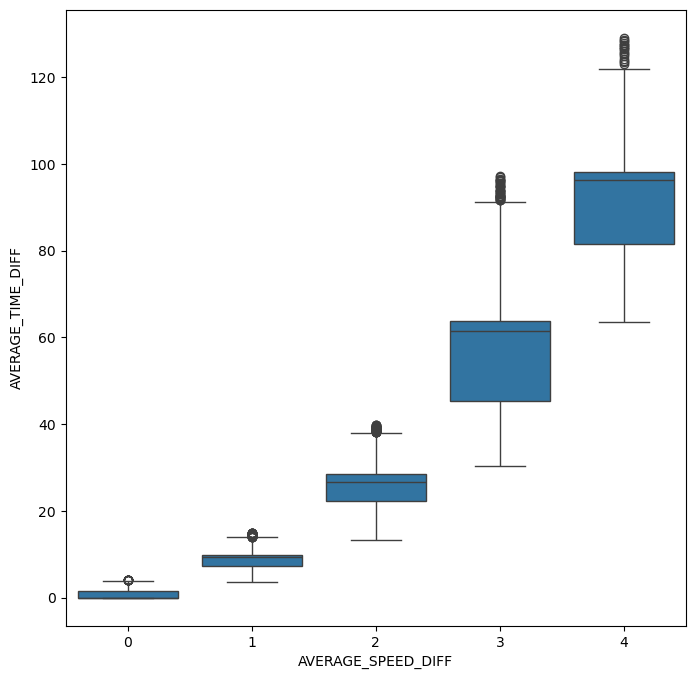

In [42]:
# Replace Outliers By Average
def replace(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 1*std
    group[outliers] = mean        
    return group

traffic_train['AVERAGE_TIME_DIFF'] = traffic_train.groupby('AVERAGE_SPEED_DIFF')['AVERAGE_TIME_DIFF'].transform(replace)
plt.subplots(figsize=(8,8))
ax = sns.boxplot(x=traffic_train["AVERAGE_SPEED_DIFF"], y=traffic_train["AVERAGE_TIME_DIFF"])

In [43]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
traffic_train[['AVERAGE_FREE_FLOW_SPEED']] = min_max_scaler.fit_transform(traffic_train[['AVERAGE_FREE_FLOW_SPEED']])
traffic_train[['AVERAGE_TIME_DIFF']] = min_max_scaler.fit_transform(traffic_train[['AVERAGE_TIME_DIFF']])
traffic_train[['AVERAGE_FREE_FLOW_TIME']] = min_max_scaler.fit_transform(traffic_train[['AVERAGE_FREE_FLOW_TIME']])
traffic_train['AVERAGE_TEMPERATURE'] = min_max_scaler.fit_transform(traffic_train[['AVERAGE_TEMPERATURE']])
traffic_train[["AVERAGE_ATMOSP_PRESSURE"]] = min_max_scaler.fit_transform(traffic_train[["AVERAGE_ATMOSP_PRESSURE"]])
traffic_train[["AVERAGE_WIND_SPEED"]] = min_max_scaler.fit_transform(traffic_train[["AVERAGE_WIND_SPEED"]])
traffic_train[["hour"]] = min_max_scaler.fit_transform(traffic_train[["hour"]])
traffic_train[["month"]] = min_max_scaler.fit_transform(traffic_train[["month"]])

traffic_test[['AVERAGE_FREE_FLOW_SPEED']] = min_max_scaler.fit_transform(traffic_test[['AVERAGE_FREE_FLOW_SPEED']])
traffic_test[['AVERAGE_TIME_DIFF']] = min_max_scaler.fit_transform(traffic_test[['AVERAGE_TIME_DIFF']])
traffic_test[['AVERAGE_FREE_FLOW_TIME']] = min_max_scaler.fit_transform(traffic_test[['AVERAGE_FREE_FLOW_TIME']])
traffic_test['AVERAGE_TEMPERATURE'] = min_max_scaler.fit_transform(traffic_test[['AVERAGE_TEMPERATURE']])
traffic_test[["AVERAGE_ATMOSP_PRESSURE"]] = min_max_scaler.fit_transform(traffic_test[["AVERAGE_ATMOSP_PRESSURE"]])
traffic_test[["AVERAGE_WIND_SPEED"]] = min_max_scaler.fit_transform(traffic_test[["AVERAGE_WIND_SPEED"]])
traffic_test[["hour"]] = min_max_scaler.fit_transform(traffic_test[["hour"]])
traffic_test[["month"]] = min_max_scaler.fit_transform(traffic_test[["month"]])

In [55]:
def is_outlier(s): 
    lower_limit = s.mean() - (s.std() * 1)
    upper_limit = s.mean() + (s.std() * 1)
    return ~s.between(lower_limit, upper_limit)

outliers_train = traffic_train['AVERAGE_TIME_DIFF'].transform(is_outlier)

In [56]:
mask = outliers_train == True

train_com_outliers = traffic_train
train_clean = traffic_train[~mask]

**Modeling**

Modelação com ambos os datasets com tratamento de outliers.

In [57]:
# Modeling
X = train_clean.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y = train_clean['AVERAGE_SPEED_DIFF'].to_frame()

X_c_outliers = train_com_outliers.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_c_outliers = train_com_outliers['AVERAGE_SPEED_DIFF'].to_frame()

In [58]:
X_treino_final = X.to_numpy()
y_treino_final = y.to_numpy()

X_c_outliers_final = X_c_outliers.to_numpy()
y_c_outliers_final = y_c_outliers.to_numpy()

teste_final_clean = traffic_test.copy()

**Random Forest com cross validation**

In [59]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

#model = RandomForestClassifier(random_state=2025, class_weight='balanced')
model = RandomForestClassifier(random_state=2025)

param_grid = {
    'n_estimators': [10, 100, 400],
    'max_features': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
res = grid_search.fit(X_c_outliers_final, np.ravel(y_c_outliers_final))
#res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions = best_model.predict(teste_final_clean)

scores = cross_val_score(grid_search, X_c_outliers_final, y_c_outliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)
#scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100)) 

teste_final_clean['Speed_Diff'] = predictions
teste_final_clean['Speed_Diff'] = teste_final_clean['Speed_Diff'].map({0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'})


create_submission_file(teste_final_clean,  prediction_col='Speed_Diff', filename='submission_15.csv')

d:\Programas\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 80.26% (+/- 0.93%)
Submissão criada: ../../submissions\submission_15.csv


'../../submissions\\submission_15.csv'